In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.metrics import mean_squared_error
#from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import RidgeCV
from catboost import CatBoostRegressor

# Define RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

import warnings
warnings.filterwarnings("ignore")

# Set seed for reproducibility
seed = 42

# Display settings
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', 200)

In [2]:
# Load data
train_raw = pd.read_csv('/kaggle/input/widsdatathon2024-challenge2/train.csv')
test_raw = pd.read_csv('/kaggle/input/widsdatathon2024-challenge2/test.csv')
solution_raw = pd.read_csv('/kaggle/input/widsdatathon2024-challenge2/solution_template.csv')

df = train_raw
df.head(5)

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
0,268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,C50912,Malignant neoplasm of unspecified site of left female breast,C773,NaN,NaN,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52,16.55,41.83,28.31,9.21,4.11,13.32,38.78,53.60,5.85,11.82,5.31,92.95,1.73,0.33,0.20,0.03,0.83,3.94,3.03,22.24,19.27,0.42,25.35,8.06,8.11,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
1,484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,C50412,Malig neoplasm of upper-outer quadrant of left female breast,C773,NaN,NaN,2745.39,51.79,43.54,11.22,12.19,11.45,11.01,11.35,14.39,14.15,9.17,5.05,49.32,50.68,49.48,15.42,26.93,8.17,3.17,41.41,51796.79,3.67,3.86,6.58,5.58,5.38,11.02,13.09,19.56,11.76,11.40,8.11,19.51,28028.04,76.71,1113.35,92026.84,638.60,29.37,10.93,35.26,35.33,12.46,6.04,18.49,36.35,52.51,7.45,9

In [3]:
df.describe()

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
count,13173.000000,13173.000000,13173.000000,4102.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13173.000000,13168.000000,13173.000000,1.316800e+04,13168.000000,13168.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13168.000000,13168.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13168.000000,13168.000000,13173.000000,13173.000000,13173.000000,13140.000000,13170.000000,13173.000000,13173.000000,13170.000000,13153.000000,13173.000000,13156.000000,13146.000000,13114.000000,13170.000000,13170.000000,13169.000000,13164.000000,13144.000000,12993.000000,13173.000000,13021.000000,13173.000000,13173.000000,13173.000000,13173.000000,13149.000000,13173.000000,13167.000000,13161.000000,13161.00000,13145.000000,13173.000000,13173.000000,13173.000000,13151.000000,13173.000000,13157.000000,13157.000000,13155.000000,13157.000000,13157.000000,13173.000000,13173.000000,13154.000000,13173.000000,13157.000000,13173.000000,13173.000000,13173.000000,13170.000000,13160.000000,13164.000000,13173.000000,13173.000000,13173.000000,13173.000000,13172.000000,13142.000000,13173.000000,13163.0

In [4]:
df['patient_state'] = np.where(df['patient_zip3'] == 630, 'MO', np.where(df['patient_zip3'] == 864, 'AZ', df['patient_state']))

# Male codes to female
df['breast_cancer_diagnosis_code'] = df['breast_cancer_diagnosis_code'].replace({
    'C50122':'C50112', 'C50221':'C50211', 'C50421':'C50411', 'C509':'C5091', 'C50922':'C50912'
})

df['Division'] = np.where(df['patient_state'] == 'MO', 'West North Central', df['patient_state'])

In [5]:
# Population columns
pop_cols = df.loc[:, 'population':'veteran'].columns.to_list()
avg_cols = df.columns[df.columns.str.startswith('Average')].tolist()

In [6]:
# inconsistencies for patient_zip3==395
df.loc[df.patient_id == 714510, pop_cols] = df.loc[df.patient_id == 636245, pop_cols].values

# inconsistencies for patient_zip3==968
df.loc[df.patient_id == 271422, pop_cols] = df.loc[df.patient_id == 271245, pop_cols].values

# inconsistencies for patient_zip3==988
df.loc[df.patient_id == 441322, pop_cols] = df.loc[df.patient_id == 982003, pop_cols].values

In [7]:
# Subset temperatures

df_avg = df[['patient_zip3', 'patient_state'] + avg_cols].drop_duplicates().sort_values(by='patient_zip3').reset_index(drop=True)

print(df_avg.shape)
df_avg.head()

(751, 74)


,patient_zip3,patient_state,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18
0,100,NY,33.44,30.84,38.45,51.26,60.18,71.91,78.55,71.32,64.49,56.13,41.99,34.79,24.37,26.97,33.92,49.99,61.76,70.54,74.73,71.48,66.73,55.69,41.66,38.25,26.53,20.84,34.33,50.51,66.72,69.80,75.96,75.25,71.07,54.58,48.87,46.33,30.06,35.06,46.52,51.23,60.48,72.47,77.11,77.54,70.08,56.80,45.79,35.42,35.37,37.89,37.02,56.56,59.65,71.17,76.11,72.17,69.26,60.80,42.89,32.62,27.67,37.57,37.87,47.55,65.06,70.23,77.12,77.72,69.82,55.79,42.04,37.18
1,101,NY,33.51,30.81,38.44,51.27,60.14,71.98,78.64,71.34,64.53,56.15,42.03,34.93,24.42,26.97,33.92,NaN,61.76,NaN,74.75,71.51,66.77,55.65,41.72,38.32,26.62,20.97,34.39,50.56,66.82,69.84,76.02,75.35,71.20,54.72,48.96,46.43,30.09,35.16,46.64,51.34,60.55,72.67,77.19,77.67,70.22,56.95,45.83,35.54,35.45,37.99,37.09,56.75,59.79,71.37,76.24,72.29,69.38,60.93,43.01,32.70,27.77,37.69,37.95,47.68,65.17,70.33,77.22,77.83,69.93,55.92,42.16,37.26
2,103,NY,34.01,31.87,38.52,51.63,60.29,71.92,78.43,71.46,64.39,56.21,42.56,35.83,25.57,26.97,34.67,51.46,61.74,70.47,74.70,71.37,66.91,56.54,41.69,38.68,27.28,21.76,35.17,50.75,66.20,69.40,75.87,75.20,70.58,54.21,48.93,47.42,30.88,35.79,46.99,51.55,60.28,71.85,77.05,77.30,70.17,56.61,46.67,36.33,36.01,39.22,37.09,56.44,59.80,70.75,76.06,72.15,69.15,60.29,43.77,32.91,28.04,38.68,38.14,47.99,65.17,70.81,76.90,77.75,69.90,56.45,42.55,37.49
3,104,NY,32.81,31.04,38.55,51.15,60.48,71.39,77.86,71.19,64.10,55.98,41.73,33.68,23.95,26.97,33.92,49.99,61.76,70.54,74.55,71.22,66.44,56.05,41.21,37.70,25.83,19.78,33.79,50.08,65.92,69.54,75.48,74.45,70.01,53.43,48.15,45.55,29.80,34.24,45.55,50.29,59.92,70.84,76.48,76.47,68.93,55.55,45.48,34.50,34.72,37.03,36.50,55.00,58.52,69.56,75.05,71.20,68.33,59.81,41.91,31.91,26.81,36.58,37.22,46.54,64.18,69.41,76.37,76.81,68.91,54.75,41.06,36.54
4,105,NY,29.13,27.78,34.54,48.12,58.59,67.86,75.06,68.19,61.44,53.31,38.38,31.92,20.03,20.35,28.98,46.86,59.60,67.73,72.00,68.59,64.27,54.66,38.04,34.64,22.47,15.58,30.56,47.75,63.83,66.95,72.20,71.25,67.61,50.64,45.29,42.99,26.84,31.00,42.83,47.79,57.43,67.18,73.73,73.14,66.10,52.98,43.58,32.09,31.65,34.71,33.61,52.17,56.50,66.72,71.75,68.49,65.46,57.39,40.07,28.83,23.77,33.59,34.47,43.69,62.71,66.81,73.70,73.99,66.41,52.29,38.51,33.56


In [8]:
mean_bmi = df.loc[df['bmi'] <= 50, 'bmi'].mean()

# Replace BMI values > 50 with the mean
df.loc[df['bmi'] > 50, 'bmi'] = mean_bmi

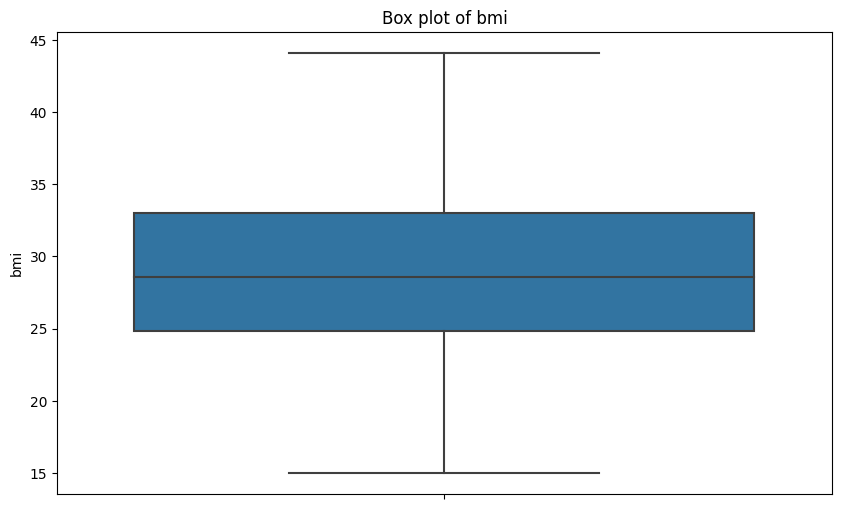

In [9]:
# Plot box plot for the 'bmi' column
def plot_box_plot(df, column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df[column])
    plt.title(f'Box plot of {column}')
    plt.show()

# Example usage with the train dataset
plot_box_plot(df, 'bmi')

In [10]:
# Include bmi info
df['bmi_missing'] = df['bmi'].isna().astype(int)
df['bmi_recoded'] = np.where(df['bmi'].isna(), 0,
                                  np.where(df['bmi'] < 18.5, 1,
                                          np.where(df['bmi'] < 25, 2,
                                                 np.where(df['bmi'] < 30, 3, 4))))
df.columns = df.columns.str.replace(' ', '_').str.replace('-', '')

print(df.shape)
df.head()

(13173, 154)


,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average_of_Jan13,Average_of_Feb13,Average_of_Mar13,Average_of_Apr13,Average_of_May13,Average_of_Jun13,Average_of_Jul13,Average_of_Aug13,Average_of_Sep13,Average_of_Oct13,Average_of_Nov13,Average_of_Dec13,Average_of_Jan14,Average_of_Feb14,Average_of_Mar14,Average_of_Apr14,Average_of_May14,Average_of_Jun14,Average_of_Jul14,Average_of_Aug14,Average_of_Sep14,Average_of_Oct14,Average_of_Nov14,Average_of_Dec14,Average_of_Jan15,Average_of_Feb15,Average_of_Mar15,Average_of_Apr15,Average_of_May15,Average_of_Jun15,Average_of_Jul15,Average_of_Aug15,Average_of_Sep15,Average_of_Oct15,Average_of_Nov15,Average_of_Dec15,Average_of_Jan16,Average_of_Feb16,Average_of_Mar16,Average_of_Apr16,Average_of_May16,Average_of_Jun16,Average_of_Jul16,Average_of_Aug16,Average_of_Sep16,Average_of_Oct16,Average_of_Nov16,Average_of_Dec16,Average_of_Jan17,Average_of_Feb17,Average_of_Mar17,Average_of_Apr17,Average_of_May17,Average_of_Jun17,Average_of_Jul17,Average_of_Aug17,Average_of_Sep17,Average_of_Oct17,Average_of_Nov17,Average_of_Dec17,Average_of_Jan18,Average_of_Feb18,Average_of_Mar18,Average_of_Apr18,Average_of_May18,Average_of_Jun18,Average_of_Jul18,Average_of_Aug18,Average_of_Sep18,Average_of_Oct18,Average_of_Nov18,Average_of_Dec18,metastatic_diagnosis_period,bmi_missing,bmi_recoded
0,268700,NaN,COMMERCIAL,AR,724,South,AR,39,F,NaN,C50912,Malignant neoplasm of unspecified site of left female breast,C773,NaN,NaN,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52,16.55,41.83,28.31,9.21,4.11,13.32,38.78,53.60,5.85,11.82,5.31,92.95,1.73,0.33,0.20,0.03,0.83,3.94,3.03,22.24,19.27,0.42,25.35,8.06,8.11,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191,1,0
1,484983,White,NaN,IL,629,Midwest,IL,55,F,35.36,C50412,Malig neoplasm of upper-outer quadrant of left female breast,C773,NaN,NaN,2745.39,51.79,43.54,11.22,12.19,11.45,11.01,11.35,14.39,14.15,9.17,5.05,49.32,50.68,49.48,15.42,26.93,8.17,3.17,41.41,51796.79,3.67,3.86,6.58,5.58,5.38,11.02,13.09,19.56,11.76,11.40,8.11,19.51,28028.04,76.71,1113.35,92026.84,638.60,29.37,10.93,35.26,35.33,12.46,6.04,18.49,36.35,52.51,7.45,9.19,5.21,88.75,6.44,0.53,0.19,0.05,0.61,3.42,2.78,20.16,16.94,0.43,26.26,6.9

In [11]:
def get_columns_with_missing_values(df, threshold=1):
    # Calculate the number of missing values
    missing_count = df.isnull().sum()

    # Calculate the percentage of missing values
    missing_percentage = (missing_count / len(df)) * 100

    # Create a DataFrame to hold the results
    missing_data = pd.DataFrame({'Missing Count': missing_count, 'Missing Percentage': missing_percentage})

    # Filter columns with missing percentage greater than the threshold
    columns_with_missing_values = missing_data[missing_data['Missing Percentage'] > threshold]

    return columns_with_missing_values

# Get columns with more than % missing values for the training dataset
missing_columns_train = get_columns_with_missing_values(df)
print("Columns with more than 10% missing values in the training dataset:")
print(missing_columns_train)

Columns with more than 10% missing values in the training dataset:
                                       Missing Count  Missing Percentage
patient_race                                    6657           50.535186
payer_type                                      1765           13.398618
bmi                                             9071           68.860548
metastatic_first_novel_treatment               13162           99.916496
metastatic_first_novel_treatment_type          13162           99.916496
Average_of_Apr14                                 180            1.366431
Average_of_Jun14                                 152            1.153875


In [12]:
# Recode categories in test data
#test_raw['breast_cancer_diagnosis_code'] = test_raw['breast_cancer_diagnosis_code'].replace({'C5021':'C50219'})

In [13]:
df=df.drop(['metastatic_first_novel_treatment','metastatic_first_novel_treatment_type', 'bmi'], axis=1)

In [14]:
df['patient_race'].fillna('Unknown', inplace=True)

In [15]:
df['payer_type'] = df['payer_type'].fillna('COMMERCIAL')

In [16]:
numerical_cols = df.select_dtypes(exclude=['object']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

In [17]:
missing_columns_train = get_columns_with_missing_values(df)
print("Columns with more than 10% missing values in the training dataset:")
print(missing_columns_train)

Columns with more than 10% missing values in the training dataset:
                  Missing Count  Missing Percentage
Average_of_Apr14            180            1.366431
Average_of_Jun14            152            1.153875


In [18]:
# Impute categorical columns using mode
for col in categorical_columns:
    if col != 'DiagPeriodL90D':
        mode = df[col].mode()[0]
        df[col].fillna(mode, inplace=True)

# Impute numerical columns using mean
for col in numerical_cols:
    if col != 'DiagPeriodL90D':
        mean = df[col].median()
        df[col].fillna(mean, inplace=True)

In [19]:
df.isna().sum()

patient_id                          0
patient_race                        0
payer_type                          0
patient_state                       0
patient_zip3                        0
Region                              0
Division                            0
patient_age                         0
patient_gender                      0
breast_cancer_diagnosis_code        0
breast_cancer_diagnosis_desc        0
metastatic_cancer_diagnosis_code    0
population                          0
density                             0
age_median                          0
age_under_10                        0
age_10_to_19                        0
age_20s                             0
age_30s                             0
age_40s                             0
age_50s                             0
age_60s                             0
age_70s                             0
age_over_80                         0
male                                0
female                              0
married     

In [20]:
df_test = test_raw.drop(['metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type'], axis=1)

# Fix bad zip 
df_test['patient_state'] = np.where(df_test['patient_zip3'] == 630, 'MO', 
                                    np.where(df_test['patient_zip3'] == 864, 'AZ', df_test['patient_state']))


# Include bmi info 
df_test['bmi_missing'] = df_test['bmi'].isna().astype(int)
df_test['bmi_recoded'] = np.where(df_test['bmi'].isna(), 0, 
                                  np.where(df_test['bmi'] < 18.5, 1, 
                                          np.where(df_test['bmi'] < 25, 2, 
                                                 np.where(df_test['bmi'] < 30, 3, 4))))

# Impute payer - most frequent value at zip from training
df_test['payer_type'] = df_test['payer_type'].fillna('COMMERCIAL')


df_test.columns = df_test.columns.str.replace(' ', '_').str.replace('-', '')

for col in categorical_columns:
    if col != 'metastatic_diagnosis_period':
        mode = df_test[col].mode()[0]
        df_test[col].fillna(mode, inplace=True)

# Impute numerical columns using mean
for col in numerical_cols:
    if col != 'metastatic_diagnosis_period':
        mean = df_test[col].median()
        df_test[col].fillna(mean, inplace=True)

print(df_test.shape)
df_test.head()

(5646, 151)


,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average_of_Jan13,Average_of_Feb13,Average_of_Mar13,Average_of_Apr13,Average_of_May13,Average_of_Jun13,Average_of_Jul13,Average_of_Aug13,Average_of_Sep13,Average_of_Oct13,Average_of_Nov13,Average_of_Dec13,Average_of_Jan14,Average_of_Feb14,Average_of_Mar14,Average_of_Apr14,Average_of_May14,Average_of_Jun14,Average_of_Jul14,Average_of_Aug14,Average_of_Sep14,Average_of_Oct14,Average_of_Nov14,Average_of_Dec14,Average_of_Jan15,Average_of_Feb15,Average_of_Mar15,Average_of_Apr15,Average_of_May15,Average_of_Jun15,Average_of_Jul15,Average_of_Aug15,Average_of_Sep15,Average_of_Oct15,Average_of_Nov15,Average_of_Dec15,Average_of_Jan16,Average_of_Feb16,Average_of_Mar16,Average_of_Apr16,Average_of_May16,Average_of_Jun16,Average_of_Jul16,Average_of_Aug16,Average_of_Sep16,Average_of_Oct16,Average_of_Nov16,Average_of_Dec16,Average_of_Jan17,Average_of_Feb17,Average_of_Mar17,Average_of_Apr17,Average_of_May17,Average_of_Jun17,Average_of_Jul17,Average_of_Aug17,Average_of_Sep17,Average_of_Oct17,Average_of_Nov17,Average_of_Dec17,Average_of_Jan18,Average_of_Feb18,Average_of_Mar18,Average_of_Apr18,Average_of_May18,Average_of_Jun18,Average_of_Jul18,Average_of_Aug18,Average_of_Sep18,Average_of_Oct18,Average_of_Nov18,Average_of_Dec18,bmi_missing,bmi_recoded
0,730681,White,COMMERCIAL,LA,713,South,West South Central,55,F,NaN,1746,Malignant neoplasm of axillary tail of female breast,C7981,4639.07,72.66,41.50,11.40,13.44,11.42,11.45,12.56,13.08,14.26,7.71,4.73,50.02,49.98,42.37,14.70,34.76,8.18,3.30,38.83,40643.61,6.77,5.02,9.93,7.53,6.36,11.54,12.60,12.70,11.60,9.53,6.43,15.97,22663.32,74.78,1698.43,113973.9,671.07,37.23,21.30,36.81,26.95,9.74,5.21,14.94,38.47,49.41,8.08,12.89,4.88,66.51,29.06,0.40,0.37,0.10,0.66,2.91,2.52,20.33,27.62,0.55,29.71,8.18,5.79,51.34,53.19,54.23,64.00,72.08,81.10,80.89,82.15,79.95,68.38,53.90,48.64,42.32,48.58,54.30,64.82,71.66,80.19,80.20,81.40,77.97,68.84,52.59,52.09,46.08,46.21,58.97,69.57,74.68,80.54,84.27,86.11,78.99,69.81,62.72,58.46,47.79,54.72,63.75,72.19,73.58,80.75,86.61,83.09,80.58,71.67,62.00,52.89,56.28,60.76,63.94,69.87,71.66,78.19,82.68,80.93,76.97,68.88,61.15,49.82,42.66,58.12,62.21,62.23,78.34,81.96,83.58,82.22,80.20,69.73,53.14,51.34,1,0
1,334212,Black,COMMERCIAL,NC,283,South,South Atlantic,60,F,40.00,C50912,Malignant neoplasm of unspecified site of left female breast,C773,10875.30,217.91,39.64,11.23,13.72,15.01,12.02,11.58,11.77,12.77,8.52,3.41,51.33,48.67,44.14,13.28,34.62,7.96,3.33,42.57,49924.38,4.59,3.83,6.58,5.27,5.90,13.16,13.99,18.14,10.65,11.39,6.49,17.88,26495.64,67.09,4034.71,119537.2,806.92,31.42,15.22,31.24,34.65,12.87,6.00,18.88,36.55,56.90,8.38,10.64,1.40,54.08,26.66,0.80,8.35,0.13,4.83,5.14,10.76,17.82,19.78,2.10,25.95,13.60,12.58,45.78,43.22,45.83,61.17,67.66,76.35,78.99,76.54,75.13,62.32,49.83,47.81,37.63,4

In [21]:
def identify_outliers(column):
    """Identify outliers in a column using the IQR method."""
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    outlier_condition = (column < (Q1 - 3 * IQR)) | (column > (Q3 + 3 * IQR))
    return outlier_condition

# Dictionary to store columns with outliers and their outlier values
columns_with_outliers = {}
outlier_counts = {}

# Check each numerical column for outliers and store the results
for col in numerical_cols:
    outliers = identify_outliers(df[col])
    num_outliers = outliers.sum()
    if num_outliers > 0:
        outlier_counts[col] = num_outliers

# Display the columns with outliers and their counts
if outlier_counts:
    print("Columns with outliers and the number of outliers in each:")
    for col, count in outlier_counts.items():
        print(f"{col}: {count} outliers")
else:
    print("No outliers found.")

Columns with outliers and the number of outliers in each:
density: 733 outliers
age_under_10: 5 outliers
age_10_to_19: 62 outliers
age_20s: 45 outliers
age_30s: 16 outliers
age_40s: 12 outliers
age_50s: 8 outliers
age_60s: 8 outliers
age_70s: 1 outliers
age_over_80: 114 outliers
male: 147 outliers
female: 147 outliers
married: 5 outliers
divorced: 5 outliers
never_married: 5 outliers
widowed: 35 outliers
family_dual_income: 4 outliers
income_household_median: 29 outliers
income_household_under_5: 30 outliers
income_household_5_to_10: 40 outliers
income_household_10_to_15: 6 outliers
income_household_15_to_20: 17 outliers
income_household_20_to_25: 7 outliers
income_household_25_to_35: 2 outliers
income_household_35_to_50: 5 outliers
income_household_50_to_75: 2 outliers
income_household_75_to_100: 2 outliers
income_individual_median: 162 outliers
home_value: 107 outliers
rent_burden: 59 outliers
education_graduate: 31 outliers
education_stem_degree: 38 outliers
labor_force_participatio

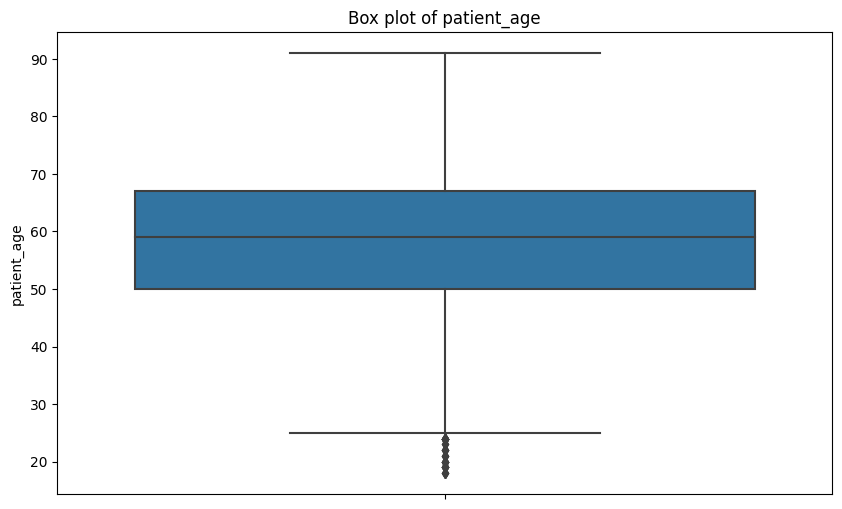

In [22]:
def plot_box_plot(df, column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df[column])
    plt.title(f'Box plot of {column}')
    plt.show()

# Example usage with the train dataset
plot_box_plot(df, 'patient_age')

In [23]:
X = df.drop(['patient_id', 'patient_race', 'breast_cancer_diagnosis_desc', 'metastatic_diagnosis_period'], axis=1)
icd = df.breast_cancer_diagnosis_code.str.startswith('17').astype(int)
y = df['metastatic_diagnosis_period']

print(X.shape, y.shape)
X.head()

(13173, 147) (13173,)


,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average_of_Jan13,Average_of_Feb13,Average_of_Mar13,Average_of_Apr13,Average_of_May13,Average_of_Jun13,Average_of_Jul13,Average_of_Aug13,Average_of_Sep13,Average_of_Oct13,Average_of_Nov13,Average_of_Dec13,Average_of_Jan14,Average_of_Feb14,Average_of_Mar14,Average_of_Apr14,Average_of_May14,Average_of_Jun14,Average_of_Jul14,Average_of_Aug14,Average_of_Sep14,Average_of_Oct14,Average_of_Nov14,Average_of_Dec14,Average_of_Jan15,Average_of_Feb15,Average_of_Mar15,Average_of_Apr15,Average_of_May15,Average_of_Jun15,Average_of_Jul15,Average_of_Aug15,Average_of_Sep15,Average_of_Oct15,Average_of_Nov15,Average_of_Dec15,Average_of_Jan16,Average_of_Feb16,Average_of_Mar16,Average_of_Apr16,Average_of_May16,Average_of_Jun16,Average_of_Jul16,Average_of_Aug16,Average_of_Sep16,Average_of_Oct16,Average_of_Nov16,Average_of_Dec16,Average_of_Jan17,Average_of_Feb17,Average_of_Mar17,Average_of_Apr17,Average_of_May17,Average_of_Jun17,Average_of_Jul17,Average_of_Aug17,Average_of_Sep17,Average_of_Oct17,Average_of_Nov17,Average_of_Dec17,Average_of_Jan18,Average_of_Feb18,Average_of_Mar18,Average_of_Apr18,Average_of_May18,Average_of_Jun18,Average_of_Jul18,Average_of_Aug18,Average_of_Sep18,Average_of_Oct18,Average_of_Nov18,Average_of_Dec18,bmi_missing,bmi_recoded
0,COMMERCIAL,AR,724,South,AR,39,F,C50912,C773,3924.87,82.63,42.58,11.61,13.03,10.87,11.80,12.29,13.22,13.47,10.07,3.64,51.43,48.57,51.05,16.72,23.57,8.66,3.01,43.99,44483.35,2.21,3.97,8.52,7.08,7.67,13.82,15.14,17.51,11.26,8.90,3.93,12.83,24048.55,72.11,1513.75,87384.33,641.39,27.52,16.55,41.83,28.31,9.21,4.11,13.32,38.78,53.60,5.85,11.82,5.31,92.95,1.73,0.33,0.20,0.03,0.83,3.94,3.03,22.24,19.27,0.42,25.35,8.06,8.11,38.55,39.88,42.75,55.16,65.17,75.98,76.75,76.45,73.67,59.73,45.18,37.43,31.67,33.83,42.35,57.72,67.35,75.92,74.28,79.59,70.84,62.39,41.89,41.46,35.24,31.10,45.50,60.94,68.49,77.69,81.35,76.28,73.32,60.32,51.00,48.37,35.76,42.89,53.21,61.07,66.29,82.78,81.52,79.52,75.61,65.76,53.85,39.56,41.59,49.01,52.28,63.40,67.11,75.78,80.58,76.16,72.91,62.68,49.73,39.80,31.71,41.69,50.22,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,1,0
1,COMMERCIAL,IL,629,Midwest,IL,55,F,C50412,C773,2745.39,51.79,43.54,11.22,12.19,11.45,11.01,11.35,14.39,14.15,9.17,5.05,49.32,50.68,49.48,15.42,26.93,8.17,3.17,41.41,51796.79,3.67,3.86,6.58,5.58,5.38,11.02,13.09,19.56,11.76,11.40,8.11,19.51,28028.04,76.71,1113.35,92026.84,638.60,29.37,10.93,35.26,35.33,12.46,6.04,18.49,36.35,52.51,7.45,9.19,5.21,88.75,6.44,0.53,0.19,0.05,0.61,3.42,2.78,20.16,16.94,0.43,26.26,6.93,9.71,34.85,36.15,39.41,54.63,65.41,73.89,74.07,74.37,70.44,57.37,42.15,33.16,26.88,28.36,40.32,56.85,66.84,75.12,72.18,77.08,67.15,58.34,38.55,38.54,32.33,25.62,43.52,58.50,66.81,75.41,78.43,73.88,70.78,58.70,50.50,46.71,32.36,38.76,51.68,58.41,64.10,78.15,79.70,78.33,72.80,63.84,50.35,34.90,39.05,45.80,48.45,60.77,65.89,

In [24]:
cols_categorical = X.columns[X.dtypes == 'object'].to_list()

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1).fit(X[cols_categorical])
X_enc = pd.concat([
    X[X.columns[~X.columns.isin(cols_categorical)]],
    pd.DataFrame(encoder.transform(X[cols_categorical]), columns=cols_categorical)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_enc, y, random_state=seed, stratify=y, test_size=.2)
print('Training size: ', X_train.shape)
print('Testing size: ', X_test.shape)

X_train.head(2)

Training size:  (10538, 147)
Testing size:  (2635, 147)


,patient_zip3,patient_age,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average_of_Jan13,Average_of_Feb13,Average_of_Mar13,Average_of_Apr13,Average_of_May13,Average_of_Jun13,Average_of_Jul13,Average_of_Aug13,Average_of_Sep13,Average_of_Oct13,Average_of_Nov13,Average_of_Dec13,Average_of_Jan14,Average_of_Feb14,Average_of_Mar14,Average_of_Apr14,Average_of_May14,Average_of_Jun14,Average_of_Jul14,Average_of_Aug14,Average_of_Sep14,Average_of_Oct14,Average_of_Nov14,Average_of_Dec14,Average_of_Jan15,Average_of_Feb15,Average_of_Mar15,Average_of_Apr15,Average_of_May15,Average_of_Jun15,Average_of_Jul15,Average_of_Aug15,Average_of_Sep15,Average_of_Oct15,Average_of_Nov15,Average_of_Dec15,Average_of_Jan16,Average_of_Feb16,Average_of_Mar16,Average_of_Apr16,Average_of_May16,Average_of_Jun16,Average_of_Jul16,Average_of_Aug16,Average_of_Sep16,Average_of_Oct16,Average_of_Nov16,Average_of_Dec16,Average_of_Jan17,Average_of_Feb17,Average_of_Mar17,Average_of_Apr17,Average_of_May17,Average_of_Jun17,Average_of_Jul17,Average_of_Aug17,Average_of_Sep17,Average_of_Oct17,Average_of_Nov17,Average_of_Dec17,Average_of_Jan18,Average_of_Feb18,Average_of_Mar18,Average_of_Apr18,Average_of_May18,Average_of_Jun18,Average_of_Jul18,Average_of_Aug18,Average_of_Sep18,Average_of_Oct18,Average_of_Nov18,Average_of_Dec18,bmi_missing,bmi_recoded,payer_type,patient_state,Region,Division,patient_gender,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code
928,726,75,2817.04,28.27,49.43,9.11,10.64,8.95,9.48,10.61,14.32,18.55,11.77,6.58,47.87,52.13,53.55,17.76,18.70,9.99,3.12,44.76,49426.98,2.20,2.15,7.83,9.17,7.49,11.01,14.42,16.15,15.83,10.66,3.11,13.76,26103.95,79.92,1168.35,129826.6,668.56,27.92,13.68,39.39,32.42,10.41,4.10,14.52,46.39,46.75,4.13,14.05,10.23,93.39,0.21,0.33,1.02,0.15,0.42,4.48,2.54,25.23,14.38,0.36,27.08,6.16,10.62,37.56,38.95,42.49,55.62,64.03,74.57,76.00,75.57,72.32,58.77,44.71,35.22,30.56,33.59,43.18,56.89,66.60,73.94,73.50,74.29,69.66,61.05,41.15,39.79,34.60,31.46,46.18,58.65,65.89,75.45,79.04,74.49,72.16,59.80,50.52,45.99,34.85,42.76,51.77,58.86,63.94,77.0,79.67,77.50,72.45,64.17,52.31,37.68,39.97,48.42,51.77,60.16,64.91,72.68,78.37,73.98,70.73,60.22,50.78,39.04,31.62,40.37,49.13,51.25,72.33,77.82,80.11,76.72,72.42,59.4,42.03,40.59,1,0,2.0,2.0,2.0,2.0,0.0,21.0,3.0
9842,907,71,28996.77,2757.96,40.64,9.87,15.30,13.14,12.18,11.46,14.15,12.52,7.14,4.23,47.63,52.37,44.47,11.39,38.24,5.89,3.46,55.71,88561.62,1.98,1.94,2.62,3.40,3.36,6.12,9.55,16.02,12.56,19.24,23.20,42.45,38429.68,56.80,9291.64,669024.6,1845.91,32.66,15.37,20.51,29.29,23.05,11.77,34.82,43.90,62.80,7.50,13.89,0.00,46.61,8.91,17.68,0.66,0.86,14.98,10.30,38.70,9.12,9.87,8.16,27.92,7.14,4.90,57.49,57.68,61.49,63.52,68.09,69.55,72.26,72.93,73.94,67.50,64.90,60.58,64.35,61.26,63.95,65.38,71.05,70.20,75.24,75.36,77.36,72.88,67.30,60.40,63.07,64.59,68.34,65.54,64.22,71.29,73.97,78.43,78.37,75.59,63.84,57.92,58.20,66.88,62.88,65.89,64.54,72.2,75.35,74.34,73.83,70.66,67.04,59.01,57.03,58.88,64.74,66.34,65.70,70.38,75.45,75.50,74.09,73.73,68.30,65

In [25]:
ctb_full = CatBoostRegressor(
    random_state=seed,
    verbose=False,
    eval_metric='RMSE'
).fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

rmse(y_test, ctb_full.predict(X_test)) # 81.37 previously, now 81.38

81.33010418657612

In [26]:
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
rerun_rfe = False
if rerun_rfe == True:
    rfe_ctb_full = ctb_full.select_features(
        X                      = X_train,
        y                      = y_train,
        eval_set               = (X_test, y_test),
        features_for_select    = X_train.columns.to_list(),                         # Features that will be selected on the RFE - here, all of them
        num_features_to_select = 10,                                                # Number of features to keep from the selected
        algorithm              = EFeaturesSelectionAlgorithm.RecursiveByShapValues, # Algorithm chosen, see -> https://github.com/catboost/catboost/blob/master/catboost/tutorials/feature_selection/select_features_tutorial.ipynb
        steps                  = 20,                                                # Number of model iterations performed in the RFE
        verbose                = False,                                             # Do not print model iterations
        train_final_model      = False,                                             # Train final model after RFE is finished
        plot                   = True                                               # plot after the RFE is finished -> very helpful for understanding if we can get a better AUC with fewer variables
    )

    # Minimum loss corresponds to the lowest RMSE
    n_todrop = np.argmin(rfe_ctb_full['loss_graph']['loss_values'])
    cols_to_keep = X.drop(rfe_ctb_full['eliminated_features_names'][:n_todrop],axis=1).columns.to_list()

else:
    cols_to_keep = [
         'patient_age',
         'self_employed',
         'Average_of_Apr13',
         'Average_of_Sep13',
         'Average_of_Aug14',
         'Average_of_Aug16',
         'bmi_missing',
         'bmi_recoded',
         'payer_type',
         'breast_cancer_diagnosis_code',
         'metastatic_cancer_diagnosis_code'
    ]

X_short = X_enc[cols_to_keep]
X_train_short = X_train[cols_to_keep]
X_test_short = X_test[cols_to_keep]
# cols_categorical_short = X_train_short.columns[X_train_short.dtypes == 'category'].to_list()

print(X_short.shape)
X_short.head()

(13173, 11)


,patient_age,self_employed,Average_of_Apr13,Average_of_Sep13,Average_of_Aug14,Average_of_Aug16,bmi_missing,bmi_recoded,payer_type,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code
0,39,11.82,55.16,73.67,79.59,79.52,1,0,0.0,40.0,3.0
1,55,9.19,54.63,70.44,77.08,78.33,0,4,0.0,26.0,3.0
2,59,13.21,67.38,79.88,82.23,84.06,1,0,0.0,7.0,3.0
3,59,21.23,62.77,72.74,73.65,71.94,1,0,1.0,39.0,3.0
4,71,14.53,60.43,67.95,68.18,66.71,1,0,0.0,6.0,30.0


In [27]:
ctb = CatBoostRegressor(
    random_state=seed,
    learning_rate=.02,
    verbose=False,
    eval_metric='RMSE'
).fit(X_train_short, y_train, eval_set=(X_test_short, y_test), use_best_model=True)

rmse(y_test, ctb.predict(X_test_short))

80.76468895769382

In [28]:
xgb = XGBRegressor(
    random_state=seed,
    learning_rate=.03,
    max_depth=4
).fit(X_train_short, y_train)
rmse(y_test, xgb.predict(X_test_short))

81.04596817570128

In [29]:
lgbm = LGBMRegressor(
    random_state=seed,
    learning_rate=.04,
    verbose=0
).fit(X_train_short, y_train)
rmse(y_test, lgbm.predict(X_test_short))

81.07465960459513

In [30]:
rf = RandomForestRegressor(
    random_state=seed,
    max_depth=6
).fit(X_train_short, y_train)
rmse(y_test, rf.predict(X_test_short))

80.89487857327943

In [31]:
gb = GradientBoostingRegressor(
    random_state=seed,
    learning_rate=.05
).fit(X_train_short, y_train)
rmse(y_test, gb.predict(X_test_short))

80.99663380962757

In [32]:
ada = AdaBoostRegressor(
    random_state=seed,
    learning_rate=.0005
).fit(X_train_short, y_train)
rmse(y_test, ada.predict(X_test_short))

81.46028436580791

In [33]:
et = ExtraTreesRegressor(
    random_state=seed,
    max_depth=9
).fit(X_train_short, y_train)
rmse(y_test, et.predict(X_test_short))

80.95314348134782

In [34]:
lgbm_tw = LGBMRegressor(
    random_state=seed,
    tweedie_variance=1.1,
    n_estimators=40,
    verbosity=-1,
    objective="tweedie",
    metric="rmse"
).fit(X_train_short, y_train)
rmse(y_test, lgbm_tw.predict(X_test_short))

81.34943639496768

In [35]:
from sklearn.neighbors import KNeighborsRegressor
kn = KNeighborsRegressor(
    n_neighbors=39,
).fit(X_train_short, y_train)
rmse(y_test, kn.predict(X_test_short))

84.6023622892882

In [36]:
def CV_predict(X, y, newdata, model, custom_cv, stratify_col=None, verbose=True, use_best_model=False):
    oof_preds, test_preds = {}, {}
    scores = []

    for fold, (train_ids, val_ids) in enumerate(custom_cv.split(X, stratify_col)):
        X_tr, y_tr = X.iloc[train_ids], y.iloc[train_ids]
        X_val, y_val = X.iloc[val_ids], y.iloc[val_ids]
        
        if use_best_model == True:
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                use_best_model=True,
                verbose=False)
            
        elif type(model) == XGBRegressor:
            model.fit(X_tr, y_tr, verbose=False)
            
        else: 
            model.fit(X_tr, y_tr)

        val_preds = model.predict(X_val)
        oof_preds.update(dict(zip(val_ids, val_preds)))
        test_preds[f'fold{fold}'] = model.predict(newdata)

        score = rmse(y_val, val_preds)
        scores.append(score)
        if verbose:
            if type(model) == CatBoostRegressor:
                print(f'Fold #{fold:>2}: {score:.5f} ({model.best_iteration_:>4} rounds)')
            else: 
                print(f'Fold #{fold:>2}: {score:.5f}')

    test_preds = pd.DataFrame.from_dict(test_preds)
    test_preds['mean'] = test_preds.mean(axis=1) # mean of fold-wise predictions
    
    oof_preds = pd.Series(oof_preds).sort_index()
    print(f'\nAvg score: {np.mean(scores):.5f} ± {np.std(scores):.5f}')
    print(f'OOF score: {rmse(y, oof_preds):.5f}')
    
    return oof_preds, test_preds

In [37]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
icd = df['breast_cancer_diagnosis_code'].str.startswith('17').astype(int)

# Encode categories in new data as well 
df_test_enc = pd.concat([
    df_test[df_test.columns[~df_test.columns.isin(cols_categorical)]],
    pd.DataFrame(encoder.transform(df_test[cols_categorical]), columns=cols_categorical)], axis=1)
df_test_short = df_test_enc[X_short.columns]

# 1. CatBoost
oof_preds_ctb, test_preds_ctb = CV_predict(X_short, y, df_test_short, ctb, cv, use_best_model=True, stratify_col=icd) 

# Encode categories in new data as well 
df_test_enc = pd.concat([
    df_test[df_test.columns[~df_test.columns.isin(cols_categorical)]],
    pd.DataFrame(encoder.transform(df_test[cols_categorical]), columns=cols_categorical)], axis=1)
df_test_short = df_test_enc[X_short.columns]

# 1. CatBoost
oof_preds_xgb, test_preds_xgb = CV_predict(X_short, y, df_test_short, XGBRegressor(), custom_cv=cv, stratify_col=icd)

Fold # 0: 85.95145 ( 551 rounds)
Fold # 1: 81.83374 ( 561 rounds)
Fold # 2: 80.45575 ( 547 rounds)
Fold # 3: 82.61145 ( 641 rounds)
Fold # 4: 82.25636 ( 741 rounds)
Fold # 5: 84.10251 ( 941 rounds)
Fold # 6: 79.45432 ( 929 rounds)
Fold # 7: 79.06383 ( 871 rounds)
Fold # 8: 82.10864 ( 830 rounds)
Fold # 9: 79.14879 ( 814 rounds)

Avg score: 81.69868 ± 2.12653
OOF score: 81.72660
Fold # 0: 91.29117
Fold # 1: 87.94682
Fold # 2: 84.84602
Fold # 3: 87.01355
Fold # 4: 86.63666
Fold # 5: 87.52909
Fold # 6: 82.88894
Fold # 7: 82.59362
Fold # 8: 85.55142
Fold # 9: 83.48694

Avg score: 85.97842 ± 2.54329
OOF score: 86.01650


In [38]:
oof_preds_xgb, test_preds_xgb = CV_predict(X_short, y, df_test_short, xgb, cv, stratify_col=icd)

Fold # 0: 85.69601
Fold # 1: 82.38399
Fold # 2: 80.93914
Fold # 3: 83.06703
Fold # 4: 82.46995
Fold # 5: 84.47672
Fold # 6: 80.24787
Fold # 7: 79.28497
Fold # 8: 82.16874
Fold # 9: 79.72429

Avg score: 82.04587 ± 1.95076
OOF score: 82.06928


In [39]:
oof_preds_lgbm, test_preds_lgbm = CV_predict(X_short, y, df_test_short, lgbm, cv, stratify_col=icd) 

Fold # 0: 85.75310
Fold # 1: 82.03315
Fold # 2: 80.60148
Fold # 3: 83.08468
Fold # 4: 82.19537
Fold # 5: 84.03000
Fold # 6: 79.49367
Fold # 7: 78.77399
Fold # 8: 82.49825
Fold # 9: 79.44234

Avg score: 81.79060 ± 2.10757
OOF score: 81.81798


In [40]:
oof_preds_rf, test_preds_rf = CV_predict(X_short, y, df_test_short, rf, cv, stratify_col=icd) 
# OOF score: 86.38329 -- default parameters

Fold # 0: 85.77174
Fold # 1: 82.11088
Fold # 2: 80.70699
Fold # 3: 82.79587
Fold # 4: 82.60500
Fold # 5: 84.24561
Fold # 6: 80.04658
Fold # 7: 79.08281
Fold # 8: 82.29784
Fold # 9: 79.58552

Avg score: 81.92489 ± 2.00350
OOF score: 81.94960


In [41]:
oof_preds_gb, test_preds_gb = CV_predict(X_short, y, df_test_short, gb, cv, stratify_col=icd) 
# OOF score: 82.05060 -- default parameters

Fold # 0: 85.82007
Fold # 1: 82.18996
Fold # 2: 80.69595
Fold # 3: 82.67605
Fold # 4: 82.46363
Fold # 5: 84.46235
Fold # 6: 80.09252
Fold # 7: 79.31133
Fold # 8: 82.05968
Fold # 9: 79.70967

Avg score: 81.94812 ± 1.97875
OOF score: 81.97223


In [42]:
oof_preds_ada, test_preds_ada = CV_predict(X_short, y, df_test_short, ada, cv, stratify_col=icd)

Fold # 0: 86.75711
Fold # 1: 82.54807
Fold # 2: 81.39528
Fold # 3: 83.92213
Fold # 4: 83.22002
Fold # 5: 85.11042
Fold # 6: 81.11161
Fold # 7: 80.02289
Fold # 8: 82.46506
Fold # 9: 80.75100

Avg score: 82.73036 ± 1.98227
OOF score: 82.75430


In [43]:
oof_preds_et, test_preds_et = CV_predict(X_short, y, df_test_short, et, cv, stratify_col=icd) 
# OOF score: 87.82207 -- default parameters

Fold # 0: 86.01750
Fold # 1: 82.12550
Fold # 2: 80.51470
Fold # 3: 83.24409
Fold # 4: 82.42483
Fold # 5: 84.37339
Fold # 6: 80.17553
Fold # 7: 79.46722
Fold # 8: 82.48557
Fold # 9: 80.00078

Avg score: 82.08291 ± 1.99075
OOF score: 82.10724


In [44]:
oof_preds_lgbm_tw, test_preds_lgbm_tw = CV_predict(X_short, y, df_test_short, lgbm_tw, cv, stratify_col=icd)

Fold # 0: 85.62746
Fold # 1: 82.25995
Fold # 2: 80.83499
Fold # 3: 82.92595
Fold # 4: 82.35164
Fold # 5: 84.28379
Fold # 6: 79.74997
Fold # 7: 78.36688
Fold # 8: 82.47264
Fold # 9: 79.69343

Avg score: 81.85667 ± 2.10667
OOF score: 81.88401


In [45]:
oof_preds_kn, test_preds_kn = CV_predict(X_short, y, df_test_short, kn, cv, stratify_col=icd) 


Fold # 0: 89.10583
Fold # 1: 85.25083
Fold # 2: 83.15807
Fold # 3: 87.06665
Fold # 4: 86.49464
Fold # 5: 86.57646
Fold # 6: 83.79639
Fold # 7: 83.28928
Fold # 8: 84.95586
Fold # 9: 83.20834

Avg score: 85.29024 ± 1.89865
OOF score: 85.31149


In [46]:
oof_preds_combined = pd.DataFrame({
    'model1': oof_preds_ctb,
    'model2': oof_preds_xgb,
    'model3': oof_preds_lgbm, 
    'model4': oof_preds_rf,
    'model5': oof_preds_gb,
    'model6': oof_preds_ada,
    'model7': oof_preds_et,
    'model8': oof_preds_lgbm_tw,
    'model9': oof_preds_kn
})

test_preds_combined = pd.DataFrame({
    'model1': test_preds_ctb['mean'],
    'model2': test_preds_xgb['mean'],
    'model3': test_preds_lgbm['mean'],
    'model4': test_preds_rf['mean'],
    'model5': test_preds_gb['mean'],
    'model6': test_preds_ada['mean'],
    'model7': test_preds_et['mean'],
    'model8': test_preds_lgbm_tw['mean'],
    'model9': test_preds_kn['mean']
})
test_preds_combined.head(3)

,model1,model2,model3,model4,model5,model6,model7,model8,model9
0,216.299715,193.809158,186.946504,191.904186,198.568988,208.154807,205.516491,201.434147,196.146154
1,76.428525,69.314056,71.989370,62.719622,68.808497,58.155390,66.290515,72.841989,73.623077
2,206.497986,216.248489,217.371634,222.861173,219.130632,219.145923,200.564423,217.657558,225.971795


In [47]:
oof_preds_combined.apply(lambda x: rmse(y, x))

model1    81.726597
model2    82.069278
model3    81.817982
model4    81.949595
model5    81.972227
model6    82.754297
model7    82.107235
model8    81.884015
model9    85.311494
dtype: float64

In [48]:
meta_cv = RidgeCV(
    alphas=[.001, .01, .05, .1, 1, 5, 10, 20, 50, 100],
    scoring='neg_root_mean_squared_error', 
    cv=5
)

# scaler = RobustScaler()
# oof_scaled = pd.DataFrame(scaler.fit_transform(oof_preds_combined), columns=oof_preds_combined.columns)

meta_cv.fit(oof_preds_combined, y)
print('R2 =', meta_cv.score(oof_preds_combined, y))
print('RMSE =', rmse(y, meta_cv.predict(oof_preds_combined))) 
meta_cv.coef_

R2 = 0.43958660163513175
RMSE = 81.57258300428072


array([ 0.39103367,  0.03766414,  0.11141418,  0.14215643,  0.25299268,
       -0.33848566,  0.15396759,  0.30847045, -0.04932254])

In [49]:
rmse(y, meta_cv.predict(oof_preds_combined))

81.57258300428072

In [50]:
rmse(y, pd.Series(meta_cv.predict(oof_preds_combined)).apply(lambda x: np.clip(x, a_min=0, a_max=np.inf)))

81.57244414611782

In [51]:
# Use ridge meta model
sub_ens = solution_raw.copy()
sub_ens['metastatic_diagnosis_period'] = meta_cv.predict( test_preds_combined )
sub_ens['metastatic_diagnosis_period'] = np.clip(sub_ens['metastatic_diagnosis_period'], a_min = 0, a_max = np.inf)
sub_ens.to_csv('submission.csv', index=False)
sub_ens.head() # LB = 82.833 

,patient_id,metastatic_diagnosis_period
0,730681,203.836605
1,334212,76.165165
2,571362,212.892001
3,907331,223.258340
4,208382,51.414077
